In [132]:
import numpy as np
import json 
import cv2
import random
import yaml

from numpy.linalg import norm
from scipy.spatial.transform import Rotation
from scipy.linalg import pinv, inv, lstsq
from scipy import optimize
import matplotlib.pyplot as plt

## Read dataset and camera parameters

In [2]:
dataset_file = open('dataset.json')
dataset_json = dataset_file.read()
data = json.loads(dataset_json)

In [3]:
with open("calibration.yaml") as stream:
    camera_data = (yaml.safe_load(stream))

M = np.array(camera_data["camera_matrix"])
distortion = np.array(camera_data["dist_coeff"])

In [4]:
def rotation_vec_to_matrix(rvec):
    rotation_object = Rotation.from_rotvec(rvec)
    return rotation_object.as_matrix()

def concat_R_and_t(R, t): 
    return np.hstack([R, t])

def get_P(M, Rt):
    return np.dot(M, Rt)

def get_C_hat(P):
    p_hat = P[:, 0:3]
    p4 = P[:,3]
    C = - np.dot(inv(p_hat), p4)
    return np.append(C, 1)

def get_point_on_ray(P, point, C, lamda): # Тут я написал не lambda, потому что зарезервированное имя питоном
    return np.dot(pinv(P), point) + lamda * C

def homo_to_euclid(point):
    point = point / point[-1]
    return point[:-1]

def project_3d_to_2d(rvec, tvec, M, point):
    points_2d, _ = cv2.projectPoints(point, 
                                 rvec, tvec, 
                                 M, 
                                 None)
    
    return points_2d

def to_plane(pointA, pointB, pointC, debug_mode = False):
    AB = pointB - pointA
    AC = pointC - pointA

    normal = np.cross(AB, AC)
    D = -np.dot(normal, pointA)

    plane = np.zeros((1, 4))
    plane[:,:3] = normal/normal[0]
    plane[0,3] = D/normal[0]
    # return normal[0]/normal[0], normal[1]/normal[0], normal[2]/normal[0], D/normal[0], \
    return plane

In [5]:
def get_rtvec(data): 
    rvec, tvec = [], []
    for key, value in data.items():
        rvec.append(np.array(value['rvec']).reshape(3))
        tvec.append(np.array(value['tvec']).reshape(3))
    return rvec, tvec

def get_2d_points(data):
    points_2d = []
    for key, value in data.items():
        points_2d.append(np.array(value['points']))
    return points_2d

In [171]:
def project_3d_to_2d(rvec, tvec, M, point):
    points_2d, jacobian = cv2.projectPoints(point, 
                                 rvec, -tvec, 
                                 M, 
                                 None)
    
    return points_2d

In [7]:
def print_point_in_image(img_path, points, radius=1):
    img = cv2.imread(img_path)
    for point in points:
        img = cv2.circle(img, (int(point[0]), int(point[1])), radius=radius, color=(0, 0, 255), thickness=-1)
    cv2.imwrite(f"{img_path}-result.png", img)

In [8]:
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)

In [40]:
def get_random_indexes(n, k):
    indexes = range(0, n)
    random_indexes = random.sample(indexes, k)
    return random_indexes

In [41]:
get_random_indexes(21, 5)

[1, 15, 19, 4, 16]

In [60]:
def get_3d_points(rvecs, tvecs, points_2d, random_indexes):
    points_3d_results = []
    
    for i in range(len(points_2d[0])):
        plane = []
        for j in random_indexes: #по изображениям
            rvec = rvecs[j]
            R = rotation_vec_to_matrix(rvec)
            tvec = tvecs[j].reshape((3,1))
            Rt = concat_R_and_t(R, tvec)
            point_first = points_2d[j][i]
            point_first = np.append(point_first, 1)
            P = get_P(M, Rt)
            C = get_C_hat(P)
            ray_point = get_point_on_ray(P, point_first, C, 10)
            first_point = get_point_on_ray(P, point_first, C, 0)
            second_point = get_point_on_ray(P, point_first, C, 10)
            first_point = homo_to_euclid(first_point)
            second_point = homo_to_euclid(second_point)
            
            # Создать случайный вектор с размерами 3
            random_point1 = np.random.rand(3)
            random_point2 = np.random.rand(3)
            plane.append(to_plane(first_point, second_point, random_point1))
            plane.append(to_plane(first_point, second_point,random_point2))
        Ab = np.vstack((plane))
        b = Ab[:,3]
        A = np.delete(Ab, 3, 1) 
        point_3d, res, rnk, s = lstsq(A, b)
        points_3d_results.append(point_3d)
    return points_3d_results

In [157]:
points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, 6))

In [167]:
points_in_image = []
r = rvecs[0]
t = tvecs[0]
img_name = 'GOPR0039.JPG'
# for result_3d_point in points_3d:
#     points_in_image.append(project_3d_to_2d(r, t, M, result_3d_point)[0][0].tolist())
p_2d, jac = project_3d_to_2d(r, t, M, points_3d[0])
points_in_image.append(p_2d[0][0].tolist())

    
print_point_in_image(f"dataset/{img_name}", points_in_image, radius=1)

[[-8.23545259e-01 -8.99725462e+01 -1.74664739e+00 -8.49715727e+01
   0.00000000e+00 -1.38355210e+01 -1.62825290e-01  0.00000000e+00
   1.00000000e+00  0.00000000e+00 -1.79307491e+01 -4.76296740e-01
   9.64604540e+00  3.29944609e+02 -1.26519301e-02]
 [ 8.71257160e+01 -1.22564007e+00  1.66325483e+01  0.00000000e+00
  -8.48661601e+01 -6.06365663e-01  0.00000000e+00 -7.14496406e-03
   0.00000000e+00  1.00000000e+00 -7.85846127e-01 -2.08745294e-02
   1.10408770e+02  9.63407887e+00 -5.54492746e-04]]


In [168]:
jac.shape

(2, 15)

In [161]:
points_3d[0]

array([-0.22089453, -0.02436529,  1.02147672])

In [75]:
loss(np.concatenate((rvecs[0],tvecs[0])), points_3d, points_2d[0], M)

48.968037774866566

In [53]:
def loss(Rtvec, points_3d, points_2d, M):
    """objective function, to be solved."""
    r = Rtvec[:3]
    t = Rtvec[3:]
    
    if len(points_3d) != len(points_2d):
        raise ValueError('Different size of points arrays.')

    points_count = len(points_3d)
    reprojection_error = 0
    
    for i in range(0, points_count-1):
        project_2d_point = project_3d_to_2d(r, t, M, points_3d[i])
        error = norm(project_2d_point - points_2d[i])
        reprojection_error += error
    
    return reprojection_error

In [54]:
def all_loss(rvecs, tvecs, points_2d, points_3d): 
    error = 0
    for i in range(len(data)):
        rvec = rvecs[i]
        tvec = tvecs[i]
        Rtvec = np.concatenate((rvec,tvec))
        error += loss(Rtvec, points_3d, points_2d[i], M)
    return error

In [55]:
all_loss(rvecs, tvecs, points_2d, points_3d)

2197.552321271026

In [183]:
def optimize_Rt(rvecs, tvecs, points_2d, points_3d):
    new_rvec, new_tvec = [], []
    for i in range(len(data)):
        rvec = rvecs[i]
        tvec = tvecs[i]
        Rtvec = np.concatenate((rvec,tvec))
        newRt = optimize.fmin(loss, x0=Rtvec, args=(points_3d, points_2d[i], M),disp=0)
        new_rvec.append(newRt[:3])
        new_tvec.append(newRt[3:])
    return new_rvec, new_tvec

In [57]:
new_rvec, new_tvec = optimize_Rt(rvecs, tvecs, points_2d, points_3d)

In [58]:
new_rvec

[array([-0.03155485, -0.02645874,  0.02281837]),
 array([-0.04007703,  0.15410282,  0.02329772]),
 array([-0.03739509,  0.17997989,  0.03046554]),
 array([-0.02318749, -0.06166457,  0.02354267]),
 array([ 0.01139989, -0.10453499,  0.02863547]),
 array([-0.00034283, -0.08866296,  0.02818498]),
 array([-0.03090351, -0.01303154,  0.02210119]),
 array([-0.03426904,  0.20654356,  0.02645075]),
 array([-0.03316491,  0.17302189,  0.03102632]),
 array([-0.0151375 , -0.04857954,  0.0265281 ]),
 array([-0.03806275,  0.06437989,  0.02676737]),
 array([-0.00064065, -0.08525323,  0.02318753]),
 array([-0.0085084 , -0.06376901,  0.02765826]),
 array([-0.0380228 ,  0.1709696 ,  0.02835471]),
 array([-0.03280401,  0.18957571,  0.02988841]),
 array([-0.03817698,  0.11962686,  0.02514584]),
 array([ 0.02084724, -0.14915316,  0.02860233]),
 array([-0.04017857,  0.02779329,  0.02422015]),
 array([-0.03630367,  0.22048283,  0.02702758]),
 array([-0.03897901,  0.07003988,  0.02445244]),
 array([-0.03722002,

## Оптимизация 3D точек и Rt без шумов

In [206]:
error = {}

In [259]:
iterate_count = 25
k = 16
# Init points
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)
points_3d = []

f_losses = []
s_losses = []
iterations = []
b_losses = []

for i in range(iterate_count):
    points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, k))
#     print(f"{len(points_2d)},    {len(points_3d)}")
    f_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    rvecs, tvecs = optimize_Rt(rvecs, tvecs, points_2d, points_3d)
    s_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    
    f_losses.append(f_loss)
    s_losses.append(s_loss)
    iterations.append(i)
    b_losses.append(min(f_loss, s_loss))
    
    
    print(f"Iter count - {i}, points finding loss - {f_loss}, Rt finding loss - {s_loss}")
# error[k] = min(np.min(s_losses), np.min(f_losses))

Iter count - 0, points finding loss - 588.1072157427869, Rt finding loss - 388.6286697807089
Iter count - 1, points finding loss - 406.7690333564764, Rt finding loss - 358.09214693301067
Iter count - 2, points finding loss - 457.66953910601825, Rt finding loss - 418.40123231193354
Iter count - 3, points finding loss - 355.36994365580745, Rt finding loss - 322.48791757125326
Iter count - 4, points finding loss - 440.28787095639245, Rt finding loss - 405.9117321578327
Iter count - 5, points finding loss - 343.2704452571043, Rt finding loss - 320.1663165229199
Iter count - 6, points finding loss - 377.8482014962348, Rt finding loss - 345.4822730879219
Iter count - 7, points finding loss - 319.1645460223396, Rt finding loss - 293.56634979524733
Iter count - 8, points finding loss - 473.52432466418054, Rt finding loss - 458.738502629777
Iter count - 9, points finding loss - 380.5008634417507, Rt finding loss - 346.5498912905707
Iter count - 10, points finding loss - 489.7097657754688, Rt fi

In [220]:
import collections
od = collections.OrderedDict(sorted(error.items()))
od

OrderedDict([(2, 672.3741055372892),
             (4, 519.5219022835945),
             (8, 318.40747229046445),
             (16, 229.51753893124834),
             (21, 249.70186802067292)])

In [214]:
error

{2: 672.3741055372892,
 4: 519.5219022835945,
 16: 229.51753893124834,
 8: 318.40747229046445,
 21: 249.70186802067292}

In [217]:
error.values()

dict_values([672.3741055372892, 519.5219022835945, 229.51753893124834, 318.40747229046445, 249.70186802067292])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


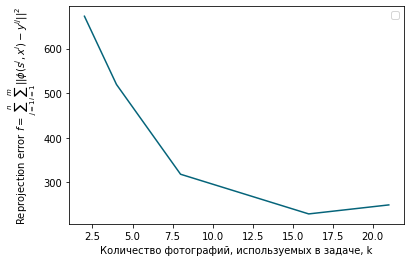

In [267]:
# Построить график
plt.plot(list(od.keys()), list(od.values()), color='#05647a')
plt.xlabel("Количество фотографий, используемых в задаче, k")
plt.ylabel("Reprojection error $f = \sum_{j=1}^{n} \sum_{i=1}^{m}|| \phi(s^j, x^i) - y^{ij} ||^2$")
plt.legend()
plt.show()

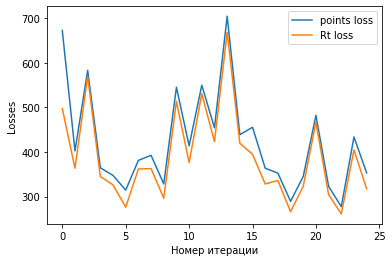

In [185]:
# Построить график
plt.plot(iterations, f_losses, label="points loss")
plt.plot(iterations, s_losses, label="Rt loss")
plt.xlabel("Номер итерации")
plt.ylabel("Losses")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


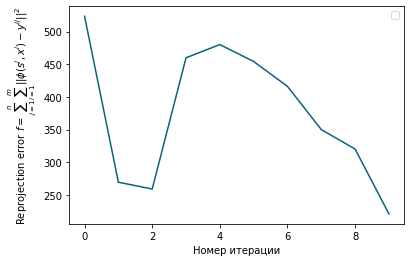

In [266]:
# Построить график
plt.plot(iterations[:10], losses_all_data[:10], color='#05647a')
plt.xlabel("Номер итерации")
plt.ylabel("Reprojection error $f = \sum_{j=1}^{n} \sum_{i=1}^{m}|| \phi(s^j, x^i) - y^{ij} ||^2$")
plt.legend()
plt.show()

In [256]:
losses_k2_t2 = b_losses

In [260]:
losses_k16_t1 = b_losses

In [ ]:
def loss_Rt(Rtvec, points_3d, points_2d, M):
    """objective function, to be solved."""
    r = Rtvec[:3]
    t = Rtvec[3:]
    
    if len(points_3d) != len(points_2d):
        raise ValueError('Different size of points arrays.')

    points_count = len(points_3d)
    reprojection_error = 0
    
    for i in range(0, points_count-1):
        project_2d_point = project_3d_to_2d(r, -t, M, points_3d[i])
        error = norm(project_2d_point - points_2d[i])
        reprojection_error += error
        print(error)
    
    return reprojection_error

In [137]:
iterate_count = 25
# Init points
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)

# Make a noise
for camera_ind in range(0, len(tvecs)):
    # Создать случайный равномерный вектор со значениями от -0.1 до 0.1 размерности 3
    min_radian = np.radians(-0.1)
    max_radian = np.radians(0.1)
    noise = np.random.uniform(min_radian, max_radian, 3)
    
    rvecs[camera_ind] = rvecs[camera_ind] + noise 
    
points_3d = []

f_losses = []
s_losses = []
iterations = []

for i in range(iterate_count):
    points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, 20))
#     print(f"{len(points_2d)},    {len(points_3d)}")
    f_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    rvecs, tvecs = optimize_Rt(rvecs, tvecs, points_2d, points_3d)
    s_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    
    f_losses.append(f_loss)
    s_losses.append(s_loss)
    iterations.append(i)
    
    print(f"Iter count - {i}, points finding loss - {f_loss}, Rt finding loss - {s_loss}")

Iter count - 0, points finding loss - 1116.2133131841706, Rt finding loss - 1067.3363303032352
Iter count - 1, points finding loss - 686.9517551518943, Rt finding loss - 656.9465084375718
Iter count - 2, points finding loss - 464.9083963827709, Rt finding loss - 478.2571462413094
Iter count - 3, points finding loss - 585.5386582664127, Rt finding loss - 576.0137304559679
Iter count - 4, points finding loss - 818.9492623024336, Rt finding loss - 850.0462538578033
Iter count - 5, points finding loss - 653.657434648733, Rt finding loss - 657.7666018467828
Iter count - 6, points finding loss - 900.5108566194486, Rt finding loss - 899.4719823422365
Iter count - 7, points finding loss - 769.5845493966198, Rt finding loss - 800.0146625195567
Iter count - 8, points finding loss - 902.3896599369364, Rt finding loss - 1004.7611278209558
Iter count - 9, points finding loss - 1062.3185206828787, Rt finding loss - 1089.843873324904
Iter count - 10, points finding loss - 1016.267339351364, Rt findin

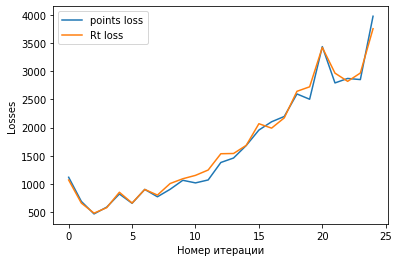

In [138]:
plt.plot(iterations, f_losses, label="points loss")
plt.plot(iterations, s_losses, label="Rt loss")
plt.xlabel("Номер итерации")
plt.ylabel("Losses")
plt.legend()
plt.show()

#### Равномерный шум (-0.1 градусов, 0.1 градусов) для R и равномерный шум (-0.1, 0.1) для t 

In [134]:
iterate_count = 25
# Init points
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)

# Make a noise
for camera_ind in range(0, len(tvecs)):
    # Создать случайный равномерный вектор со значениями от -0.1 до 0.1 градусов размерности 3
    min_radian = np.radians(-0.1)
    max_radian = np.radians(0.1)
    noise = np.random.uniform(min_radian, max_radian, 3)
    
    rvecs[camera_ind] = rvecs[camera_ind] + noise 
    
    # Создать случайный равномерный вектор со значениями от -0.1 до 0.1 размерности 3
    noise = np.random.uniform(-0.1, 0.1, 3)
    tvecs[camera_ind] = tvecs[camera_ind] + noise 
    
points_3d = []

f_losses = []
s_losses = []
iterations = []

for i in range(iterate_count):
    points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, 20))
#     print(f"{len(points_2d)},    {len(points_3d)}")
    f_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    rvecs, tvecs = optimize_Rt(rvecs, tvecs, points_2d, points_3d)
    s_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    
    f_losses.append(f_loss)
    s_losses.append(s_loss)
    iterations.append(i)
    
    print(f"Iter count - {i}, points finding loss - {f_loss}, Rt finding loss - {s_loss}")

Iter count - 0, points finding loss - 10313.421468893916, Rt finding loss - 8602.87595877128
Iter count - 1, points finding loss - 13018.14478872149, Rt finding loss - 12651.13557663438
Iter count - 2, points finding loss - 12290.622079103081, Rt finding loss - 12570.76500519916
Iter count - 3, points finding loss - 8910.880170021452, Rt finding loss - 8722.089315125515
Iter count - 4, points finding loss - 67204.88188687773, Rt finding loss - 15129.505932250378
Iter count - 5, points finding loss - 32623.047950798587, Rt finding loss - 31963.17070292911
Iter count - 6, points finding loss - 48034.5152524053, Rt finding loss - 38259.77530742114
Iter count - 7, points finding loss - 17602.50730569362, Rt finding loss - 11638.75617770026
Iter count - 8, points finding loss - 64734.10314542223, Rt finding loss - 87014.07476123347
Iter count - 9, points finding loss - 24597.82165198798, Rt finding loss - 14199.827600122566
Iter count - 10, points finding loss - 24094.73501803291, Rt findin

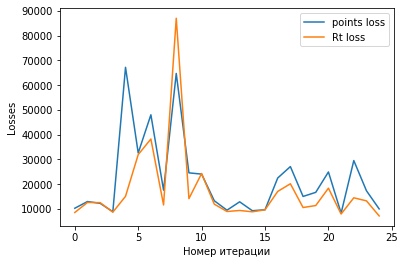

In [135]:
plt.plot(iterations, f_losses, label="points loss")
plt.plot(iterations, s_losses, label="Rt loss")
plt.xlabel("Номер итерации")
plt.ylabel("Losses")
plt.legend()
plt.show()

### Оптимизация с помощью метода Ньютона

In [222]:
def optimize_Rt_newton(rvecs, tvecs, points_2d, points_3d):
    new_rvec, new_tvec = [], []
    for i in range(len(data)):
        rvec = rvecs[i]
        tvec = tvecs[i]
        Rtvec = np.concatenate((rvec,tvec))
        newRt = optimize.newton(loss, x0=Rtvec, args=(points_3d, points_2d[i], M),disp=0)
        new_rvec.append(newRt[:3])
        new_tvec.append(newRt[3:])
    return new_rvec, new_tvec

In [223]:
iterate_count = 25
# Init points
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)
points_3d = []

f_losses = []
s_losses = []
iterations = []

for i in range(iterate_count):
    points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, 20))
#     print(f"{len(points_2d)},    {len(points_3d)}")
    f_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    rvecs, tvecs = optimize_Rt(rvecs, tvecs, points_2d, points_3d)
    s_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    
    f_losses.append(f_loss)
    s_losses.append(s_loss)
    iterations.append(i)
    
    print(f"Iter count - {i}, points finding loss - {f_loss}, Rt finding loss - {s_loss}")

Iter count - 0, points finding loss - 658.5849101406731, Rt finding loss - 522.5018829279381
Iter count - 1, points finding loss - 529.6844398579024, Rt finding loss - 469.0200146474282
Iter count - 2, points finding loss - 343.92234615347735, Rt finding loss - 298.23054727402166
Iter count - 3, points finding loss - 389.972495697318, Rt finding loss - 378.719348848513
Iter count - 4, points finding loss - 408.50584291168707, Rt finding loss - 391.05207657246393
Iter count - 5, points finding loss - 246.10301459242444, Rt finding loss - 207.3201664891085
Iter count - 6, points finding loss - 346.81696203038587, Rt finding loss - 333.9490234235498
Iter count - 7, points finding loss - 320.7551791517899, Rt finding loss - 282.6111015327247
Iter count - 8, points finding loss - 353.4091901798192, Rt finding loss - 306.23760420324015
Iter count - 9, points finding loss - 461.76149009476893, Rt finding loss - 406.76467334480856
Iter count - 10, points finding loss - 430.79972583506344, Rt f

### least_squares 

In [227]:
def optimize_Rt_ls(rvecs, tvecs, points_2d, points_3d):
    new_rvec, new_tvec = [], []
    for i in range(len(data)):
        rvec = rvecs[i]
        tvec = tvecs[i]
        Rtvec = np.concatenate((rvec,tvec))
        optimizeResult = optimize.least_squares(loss, x0=Rtvec, args=(points_3d, points_2d[i], M), method='lm')
        newRT = optimizeResult.x
#         print(optimizeResult.x)
        new_rvec.append(newRT[:3])
        new_tvec.append(newRT[3:])
    return new_rvec, new_tvec

In [225]:
iterate_count = 25
# Init points
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)
points_3d = []

f_losses = []
s_losses = []
iterations = []

for i in range(iterate_count):
    points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, 20))
#     print(f"{len(points_2d)},    {len(points_3d)}")
    f_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    rvecs, tvecs = optimize_Rt_ls(rvecs, tvecs, points_2d, points_3d)
    s_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    
    f_losses.append(f_loss)
    s_losses.append(s_loss)
    iterations.append(i)
    
    print(f"Iter count - {i}, points finding loss - {f_loss}, Rt finding loss - {s_loss}")

Iter count - 0, points finding loss - 629.3541520834052, Rt finding loss - 461.71324959407
Iter count - 1, points finding loss - 449.07731424272697, Rt finding loss - 427.9178401003265
Iter count - 2, points finding loss - 378.6341535079421, Rt finding loss - 335.2870833204377
Iter count - 3, points finding loss - 402.78129813624804, Rt finding loss - 381.2404132100283
Iter count - 4, points finding loss - 460.54816620754127, Rt finding loss - 435.65569625167234
Iter count - 5, points finding loss - 451.6738815387874, Rt finding loss - 429.7103311814403
Iter count - 6, points finding loss - 557.7478920630322, Rt finding loss - 530.0857523287424
Iter count - 7, points finding loss - 356.0928182176995, Rt finding loss - 337.9879106494513
Iter count - 8, points finding loss - 380.19625815153114, Rt finding loss - 354.3250214481777
Iter count - 9, points finding loss - 477.41553582247656, Rt finding loss - 457.96096897049625
Iter count - 10, points finding loss - 652.6232527718303, Rt find

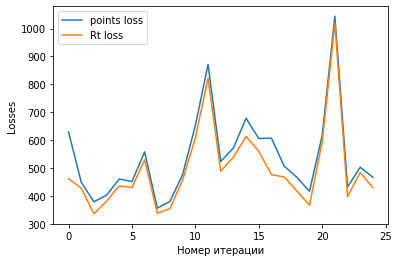

In [226]:
plt.plot(iterations, f_losses, label="points loss")
plt.plot(iterations, s_losses, label="Rt loss")
plt.xlabel("Номер итерации")
plt.ylabel("Losses")
plt.legend()
plt.show()

### LM Method

In [228]:
iterate_count = 25
# Init points
rvecs, tvecs = get_rtvec(data)
points_2d = get_2d_points(data)
points_3d = []

f_losses = []
s_losses = []
iterations = []

for i in range(iterate_count):
    points_3d = get_3d_points(rvecs, tvecs, points_2d, get_random_indexes(21, 20))
#     print(f"{len(points_2d)},    {len(points_3d)}")
    f_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    rvecs, tvecs = optimize_Rt_ls(rvecs, tvecs, points_2d, points_3d)
    s_loss = all_loss(rvecs, tvecs, points_2d, points_3d)
    
    f_losses.append(f_loss)
    s_losses.append(s_loss)
    iterations.append(i)
    
    print(f"Iter count - {i}, points finding loss - {f_loss}, Rt finding loss - {s_loss}")

ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variables.

In [ ]:
plt.plot(iterations, f_losses, label="points loss")
plt.plot(iterations, s_losses, label="Rt loss")
plt.xlabel("Номер итерации")
plt.ylabel("Losses")
plt.legend()
plt.show()